In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=659357b07abebc973f86ccc67273bfda5c7181275db448dab9050ad0d71746c8
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
!mkdir /root/.kaggle/

In [3]:
pwd

'/content'

In [4]:
!cp /content/kaggle.json /root/.kaggle   
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:04<00:00, 43.0MB/s]
100% 5.76G/5.76G [02:04<00:00, 49.7MB/s]


In [6]:
!unzip cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954399974.jpg  
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  in

In [7]:
import pandas as pd
import shutil
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')
import random
import glob
from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(2)
import seaborn as sns
#np.random.seed
from sklearn.model_selection import train_test_split
from numpy.random import seed 
seed(42)# keras seed fixing import tensorflow as tf tf.random.set_seed(42)# tensorflow seed fixing
tf.random.set_seed(42)# tensorflow seed fixing
#from focal_loss import SparseCategoricalFocalLoss

In [8]:
df = pd.read_csv("train.csv", index_col= False)
df.head(2)
len(df)

21397

In [9]:
#Splitting the DF
df.label = df.label.astype('str')

train_df, test_df = train_test_split(df, test_size=0.4, random_state=11)
#val_df, test_df = train_test_split(test_df, test_size=0.5)


In [10]:
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.model_selection import RepeatedStratifiedKFold

In [11]:
Train_dir = '/content/train_images/'

In [12]:
#splitting the data using stratified cross validation
Y = train_df['label']

kf = KFold(n_splits = 3)
                         
skf = StratifiedKFold(n_splits = 3, random_state = 7, shuffle = True) 

In [13]:
#BATCH_SIZE = 16
IMAGE_SIZE = [512, 512]
#IMAGE_SIZE = [224, 224] #for cropnet
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 8
#STEPS_PER_EPOCH = len(training_data)*0.6 / BATCH_SIZE
#VALIDATION_STEPS = len(validation_data)*0.4/ BATCH_SIZE
#VALIDATION_STEPS = 100
EPOCHS = 50
TARGET_SIZE = 512
#TARGET_SIZE = 300

In [14]:
idg = ImageDataGenerator(
    validation_split = 0.2,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

In [15]:
#getting folds and creating data generators
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = '/content/saved_models/'
fold_var = 1
n = 12838

for train_index, val_index in skf.split(np.zeros(n),Y):
	training_data = train_df.iloc[train_index].astype(str)
	validation_data = train_df.iloc[val_index].astype(str)
 
 
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = Train_dir,
						       x_col = "image_id", y_col = "label", batch_size = BATCH_SIZE, target_size=(224,224),
						       class_mode = "sparse", shuffle = True, seed=42)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = Train_dir,
							x_col = "image_id", y_col = "label", batch_size = BATCH_SIZE,target_size=(224,224),
							class_mode = "sparse", shuffle = True, seed=42)
 
  

Found 8558 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.
Found 8559 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.
Found 8559 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [16]:
test_data = test_df.astype(str)

test_data_generator = idg.flow_from_dataframe(test_df, directory = Train_dir, target_size=(224,224),
              batch_size = BATCH_SIZE, x_col = "image_id", y_col = "label", class_mode="sparse", seed=42)

Found 8559 validated image filenames belonging to 5 classes.


**Declaring the models**

In [17]:
img_width = 299
img_height = 299
img_width1 = 224
img_height1 = 224

In [18]:
#create teacher and student models
Resnet_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
MobileNet_layer1 = tf.keras.applications.MobileNet(include_top=False, weights ='imagenet', alpha=1.0, input_shape=(img_width1, img_height1,3))

17227776/17225924 [==============================] - 0s 0us/step


In [19]:
#Layer 1
Resnet_model_layer1 = hub.KerasLayer(
    Resnet_model, input_shape=(img_width, img_height, 3), trainable=True)


In [20]:
#create teacher and student models
# Create the teacher
teacher = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width1, img_height1,3)),
  Resnet_model_layer1,
  tf.keras.layers.Dense(100, activation = "relu"), 
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(5, activation = "softmax")      
  
], 
  name = "teacher",
  )

# Create the student
student = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width1,img_height1,3)),
        MobileNet_layer1,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(5, activation = 'softmax')
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)


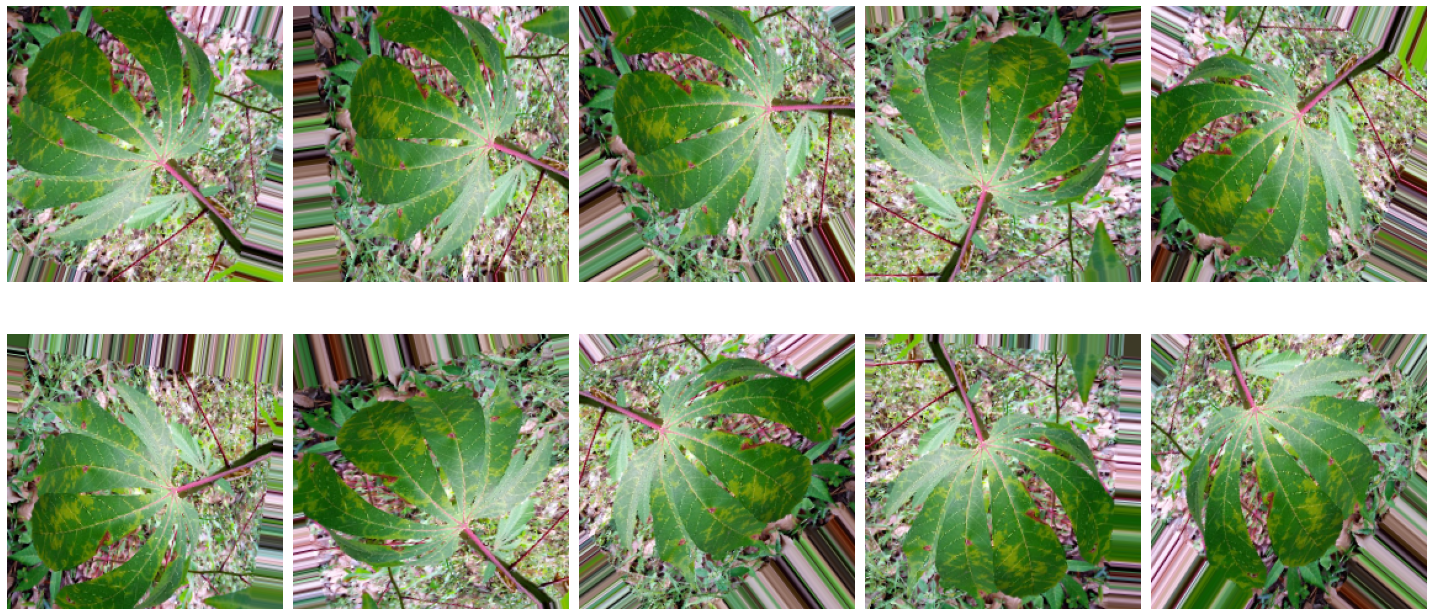

In [ ]:
# data augmentation
aug_images = [train_data_generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Train teacher as usual
teacher.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['accuracy'])

In [ ]:
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
history_teacher = teacher.fit(train_data_generator,
			    epochs=50,
			    validation_data=valid_data_generator,
          callbacks=[model_save, early_stop], shuffle=False)

Epoch 1/50
1070/1070 [==============================] - 259s 235ms/step - loss: 1.2604 - accuracy: 0.6479 - val_loss: 1.0556 - val_accuracy: 0.7118

Epoch 00001: val_loss improved from inf to 1.05564, saving model to ./resnet_50.h5
Epoch 2/50
1070/1070 [==============================] - 246s 230ms/step - loss: 1.1009 - accuracy: 0.6892 - val_loss: 1.0040 - val_accuracy: 0.7385

Epoch 00002: val_loss improved from 1.05564 to 1.00399, saving model to ./resnet_50.h5
Epoch 3/50
1070/1070 [==============================] - 241s 225ms/step - loss: 1.0467 - accuracy: 0.7204 - val_loss: 1.0118 - val_accuracy: 0.7282

Epoch 00003: val_loss did not improve from 1.00399
Epoch 4/50
1070/1070 [==============================] - 240s 225ms/step - loss: 0.9897 - accuracy: 0.7415 - val_loss: 0.9038 - val_accuracy: 0.7663

Epoch 00004: val_loss improved from 1.00399 to 0.90380, saving model to ./resnet_50.h5
Epoch 5/50
1070/1070 [==============================] - 245s 229ms/step - loss: 0.9357 - accurac

In [ ]:
teacher.save('/content/resnet_50.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/resnet_50.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
new_model.evaluate(test_data_generator)

1070/1070 [==============================] - 163s 152ms/step - loss: 0.7184 - accuracy: 0.8287


[0.7184200882911682, 0.8287183046340942]

In [ ]:
teacher.evaluate(test_data_generator)

1070/1070 [==============================] - 162s 151ms/step - loss: 0.7299 - accuracy: 0.8223


[0.7299367785453796, 0.8222923278808594]

**Distill teacher to student**

In [ ]:
test_data_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [ ]:
x,y = train_data_generator.next()

In [ ]:
#construct the distiller class
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
hist = distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
# Distill teacher to student
hist = distiller.fit(train_data_generator, epochs=15, shuffle=False)

Epoch 1/15
1070/1070 [==============================] - 169s 154ms/step - sparse_categorical_accuracy: 0.7080 - student_loss: 0.7796 - distillation_loss: 1.9925e-04
Epoch 2/15
1070/1070 [==============================] - 164s 153ms/step - sparse_categorical_accuracy: 0.7524 - student_loss: 0.7108 - distillation_loss: 1.7453e-04
Epoch 3/15
1070/1070 [==============================] - 163s 153ms/step - sparse_categorical_accuracy: 0.7463 - student_loss: 0.6754 - distillation_loss: 1.6595e-04
Epoch 4/15
1070/1070 [==============================] - 164s 153ms/step - sparse_categorical_accuracy: 0.7698 - student_loss: 0.6571 - distillation_loss: 1.6066e-04
Epoch 5/15
1070/1070 [==============================] - 165s 154ms/step - sparse_categorical_accuracy: 0.7694 - student_loss: 0.6445 - distillation_loss: 1.4909e-04
Epoch 6/15
1070/1070 [==============================] - 167s 156ms/step - sparse_categorical_accuracy: 0.7776 - student_loss: 0.6182 - distillation_loss: 1.4054e-04
Epoch 7/15

In [ ]:
hist.history

AttributeError: ignored

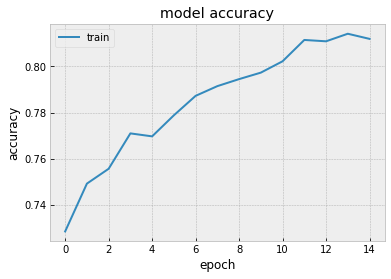

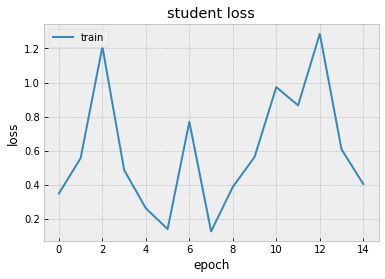

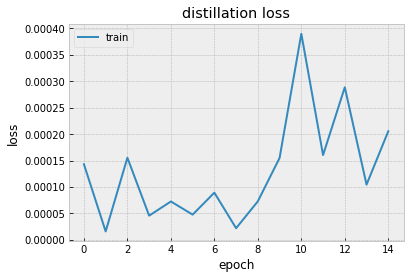

In [ ]:
#summary history for accuracy
plt.plot(hist.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# Evaluate student on test dataset
distiller.evaluate(test_data_generator)

1070/1070 [==============================] - 157s 146ms/step - sparse_categorical_accuracy: 0.7990 - student_loss: 0.5912


[0.7990419268608093, 0.5399885773658752]

In [ ]:
#construct the distiller class
class Distiller1(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller1, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller1, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_1 = Distiller1(student=student, teacher=teacher)
hist = distiller_1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
#Early stopping using distillation loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'distillation_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'distillation_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student
hist2 = distiller_1.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

Epoch 1/30
1070/1070 [==============================] - 172s 158ms/step - sparse_categorical_accuracy: 0.8242 - student_loss: 0.5046 - distillation_loss: 1.0634e-04

Epoch 00001: distillation_loss improved from inf to 0.00023, saving model to ./teacher_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 169s 158ms/step - sparse_categorical_accuracy: 0.8242 - student_loss: 0.4985 - distillation_loss: 1.0342e-04

Epoch 00002: distillation_loss improved from 0.00023 to 0.00012, saving model to ./teacher_resnet_50.h5
Epoch 3/30
1070/1070 [==============================] - 172s 160ms/step - sparse_categorical_accuracy: 0.8343 - student_loss: 0.4843 - distillation_loss: 1.0152e-04

Epoch 00003: distillation_loss improved from 0.00012 to 0.00003, saving model to ./teacher_resnet_50.h5
Epoch 4/30
1070/1070 [==============================] - 170s 159ms/step - sparse_categorical_accuracy: 0.8309 - student_loss: 0.4889 - distillation_loss: 1.0343e-04

Epoch 00004: distillation_lo

In [ ]:
hist2.history

{'distillation_loss': [0.00022634385095443577,
  0.00012479878205340356,
  2.524694900785107e-05,
  0.00013388751540333033,
  0.00021147762890905142,
  4.299444117350504e-05],
 'sparse_categorical_accuracy': [0.8238111734390259,
  0.8282509446144104,
  0.8312886953353882,
  0.8315223455429077,
  0.8312886953353882,
  0.8365463018417358],
 'student_loss': [0.9353179335594177,
  0.5401653051376343,
  0.2736956477165222,
  0.3319375813007355,
  0.7159000635147095,
  0.3434571921825409]}

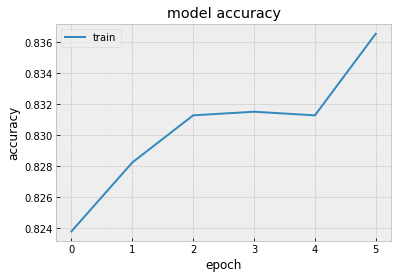

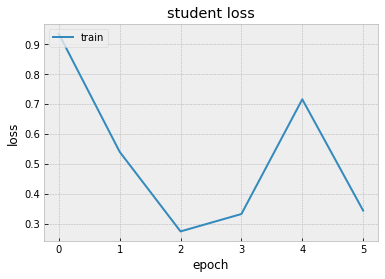

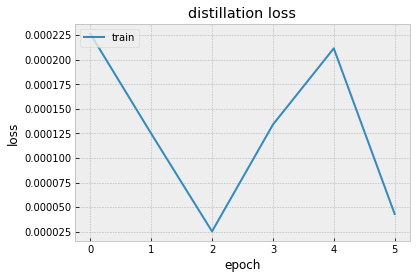

In [ ]:
#summary history for accuracy
plt.plot(hist2.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist2.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist2.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_1.evaluate(test_data_generator)

1070/1070 [==============================] - 159s 148ms/step - sparse_categorical_accuracy: 0.8111 - student_loss: 0.5579


[0.8110760450363159, 0.3063218891620636]

In [ ]:
#construct the distiller class
class Distiller2(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller2, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller2, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_2 = Distiller2(student=student, teacher=teacher)
hist = distiller_2.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher1_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'student_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'student_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student
hist3 = distiller_2.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

Epoch 1/30
1070/1070 [==============================] - 173s 158ms/step - sparse_categorical_accuracy: 0.8346 - student_loss: 0.4998 - distillation_loss: 1.0363e-04

Epoch 00001: student_loss improved from inf to 0.38767, saving model to ./teacher1_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 170s 159ms/step - sparse_categorical_accuracy: 0.8359 - student_loss: 0.4853 - distillation_loss: 1.0311e-04

Epoch 00002: student_loss improved from 0.38767 to 0.29057, saving model to ./teacher1_resnet_50.h5
Epoch 3/30
1070/1070 [==============================] - 172s 161ms/step - sparse_categorical_accuracy: 0.8327 - student_loss: 0.4865 - distillation_loss: 1.0598e-04

Epoch 00003: student_loss improved from 0.29057 to 0.15379, saving model to ./teacher1_resnet_50.h5
Epoch 4/30
1070/1070 [==============================] - 172s 161ms/step - sparse_categorical_accuracy: 0.8340 - student_loss: 0.4873 - distillation_loss: 1.0208e-04

Epoch 00004: student_loss did not improv

In [ ]:
hist3.history

{'distillation_loss': [3.933652988052927e-05,
  6.164197839098051e-05,
  2.2428244847105816e-05,
  0.00013635429786518216,
  1.5380925106001087e-05,
  2.6509009330766276e-05,
  4.296327915653819e-06,
  2.970354034914635e-05],
 'sparse_categorical_accuracy': [0.8291856646537781,
  0.8326907157897949,
  0.8290688395500183,
  0.831405520439148,
  0.8287183046340942,
  0.8374810218811035,
  0.8342096209526062,
  0.83899986743927],
 'student_loss': [0.38766974210739136,
  0.2905701696872711,
  0.15379464626312256,
  0.3805442154407501,
  0.20133912563323975,
  0.9613557457923889,
  0.37356653809547424,
  0.38651785254478455]}

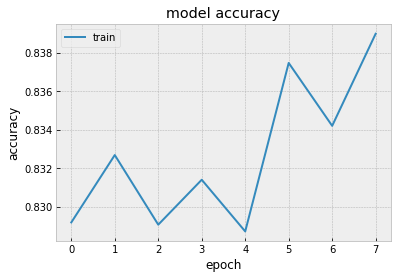

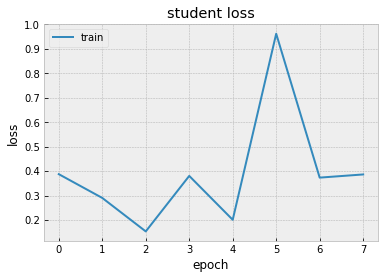

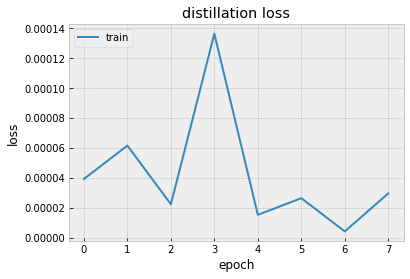

In [ ]:
#summary history for accuracy
plt.plot(hist3.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist3.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist3.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_2.evaluate(test_data_generator)

1070/1070 [==============================] - 158s 147ms/step - sparse_categorical_accuracy: 0.8218 - student_loss: 0.5082


[0.8218249678611755, 0.1772918999195099]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#getting the true class labels
y_true_labels = test_data_generator.classes
#y_true_labels = testgen.class_indices
print(y_true_labels)
type(y_true_labels)

[2, 3, 1, 2, 3, 3, 3, 3, 0, 3, 2, 1, 1, 3, 2, 1, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 3, 1, 2, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2, 1, 2, 1, 3, 2, 4, 3, 3, 2, 3, 3, 2, 3, 2, 4, 1, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 4, 2, 3, 4, 1, 3, 3, 4, 3, 4, 4, 3, 3, 2, 3, 3, 3, 4, 3, 0, 4, 0, 3, 3, 4, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 4, 3, 3, 0, 2, 3, 3, 3, 4, 4, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 2, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 2, 2, 3, 3, 1, 4, 2, 2, 3, 3, 3, 3, 2, 4, 3, 4, 1, 3, 4, 3, 3, 3, 3, 3, 1, 4, 3, 4, 4, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 4, 3, 3, 2, 3, 0, 4, 2, 2, 3, 3, 

list

In [ ]:
TEST_STEPS = len(test_df) / BATCH_SIZE

In [ ]:
#Y prediction
Y_pred = distiller_2.predict_generator(test_data_generator, TEST_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true_labels, y_pred))

Confusion Matrix
[[  23   32   39  284   55]
 [  43   80   88  577  104]
 [  45  104   67  612  124]
 [ 268  465  430 3384  679]
 [  64   89   99  671  133]]


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Classification Report')
target_names = ['0','1','2','3','4']
print(classification_report(test_data_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       433
           1       0.10      0.09      0.10       892
           2       0.09      0.07      0.08       952
           3       0.61      0.65      0.63      5226
           4       0.12      0.13      0.12      1056

    accuracy                           0.43      8559
   macro avg       0.20      0.20      0.20      8559
weighted avg       0.41      0.43      0.42      8559



**Using Temperature = 5**

In [ ]:
#construct the distiller class
class Distiller3(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller3, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=5,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller3, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


    def train_step(self, data):
        # Unpack data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    
    def call (self, data):
        #teacher_predictions = self.teacher(data, training=False)
        student_predictions = self.student(data, training=True)
        return student_predictions


    def test_step(self, data):
        # Unpack the data
        x, y = data
        #x = np.concatenate([data.next()[0] for i in range(data.__len__())])
        #y = np.concatenate([data.next()[1] for i in range(data.__len__())])

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
# Initialize and compile distiller
distiller_3 = Distiller3(student=student, teacher=teacher)
hist = distiller_3.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10
  
)

In [ ]:
# Initialize and compile distiller
distiller_3_1 = Distiller3(student=student, teacher=teacher)
hist = distiller_3_1.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1, temperature = 10)

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher3_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'distillation_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'distillation_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
# Distill teacher to student
hist4 = distiller_3_1.fit(train_data_generator, epochs=30,callbacks=[model_save, early_stop], shuffle=False)

Epoch 1/30
1070/1070 [==============================] - 161s 148ms/step - sparse_categorical_accuracy: 0.8400 - student_loss: 0.4550 - distillation_loss: 9.5911e-05

Epoch 00001: distillation_loss improved from inf to 0.00020, saving model to ./teacher3_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 159s 148ms/step - sparse_categorical_accuracy: 0.8460 - student_loss: 0.4419 - distillation_loss: 9.5770e-05

Epoch 00002: distillation_loss improved from 0.00020 to 0.00015, saving model to ./teacher3_resnet_50.h5
Epoch 3/30
1070/1070 [==============================] - 160s 149ms/step - sparse_categorical_accuracy: 0.8492 - student_loss: 0.4397 - distillation_loss: 9.4656e-05

Epoch 00003: distillation_loss improved from 0.00015 to 0.00003, saving model to ./teacher3_resnet_50.h5
Epoch 4/30
1070/1070 [==============================] - 161s 150ms/step - sparse_categorical_accuracy: 0.8448 - student_loss: 0.4393 - distillation_loss: 9.3305e-05

Epoch 00004: distillation

In [ ]:
hist4.history

{'distillation_loss': [0.00020265555940568447,
  0.00015313763287849724,
  2.8943059078301303e-05,
  3.0947579944040626e-05,
  0.00010751043009804562,
  1.7275551726925187e-05],
 'sparse_categorical_accuracy': [0.8420376181602478,
  0.8461268544197083,
  0.8519687056541443,
  0.8489309549331665,
  0.8450753688812256,
  0.848697304725647],
 'student_loss': [0.3385591208934784,
  0.3971865475177765,
  0.1174621731042862,
  0.41790905594825745,
  0.6972465515136719,
  0.0739588811993599]}

In [ ]:
distiller_3_1.evaluate(test_data_generator)

1070/1070 [==============================] - 155s 144ms/step - sparse_categorical_accuracy: 0.8287 - student_loss: 0.4996


[0.8287183046340942, 1.0640857219696045]

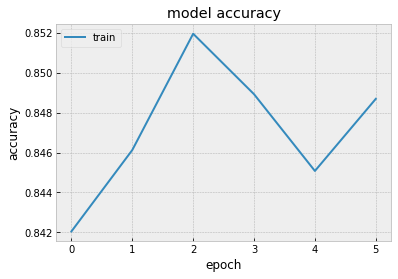

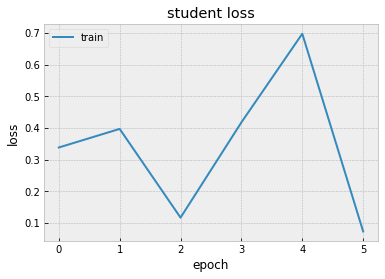

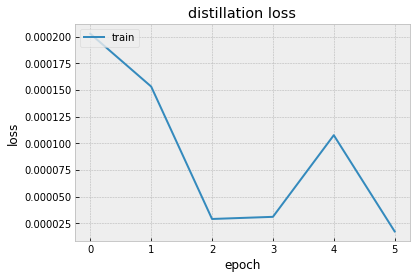

In [ ]:
#summary history for accuracy
plt.plot(hist4.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist4.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist4.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#Early stopping using student loss
#call backs
model_save = tf.keras.callbacks.ModelCheckpoint('./teacher4_resnet_50.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'student_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'student_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

In [ ]:
hist6 = distiller_3.fit(train_data_generator, epochs=30, shuffle=False, callbacks=[model_save, early_stop])

Epoch 1/30
1070/1070 [==============================] - 162s 148ms/step - sparse_categorical_accuracy: 0.8327 - student_loss: 0.4774 - distillation_loss: 1.0221e-04

Epoch 00001: student_loss improved from inf to 0.75550, saving model to ./teacher4_resnet_50.h5
Epoch 2/30
1070/1070 [==============================] - 158s 148ms/step - sparse_categorical_accuracy: 0.8323 - student_loss: 0.4655 - distillation_loss: 9.8611e-05

Epoch 00002: student_loss improved from 0.75550 to 0.32608, saving model to ./teacher4_resnet_50.h5
Epoch 3/30
1070/1070 [==============================] - 157s 147ms/step - sparse_categorical_accuracy: 0.8361 - student_loss: 0.4695 - distillation_loss: 9.8439e-05

Epoch 00003: student_loss did not improve from 0.32608
Epoch 4/30
1070/1070 [==============================] - 159s 149ms/step - sparse_categorical_accuracy: 0.8415 - student_loss: 0.4581 - distillation_loss: 9.8080e-05

Epoch 00004: student_loss improved from 0.32608 to 0.12586, saving model to ./teacher

In [ ]:
hist6.history

{'distillation_loss': [2.6735160645330325e-05,
  5.6652057537576184e-05,
  5.396507913246751e-05,
  0.00010113196185557172,
  2.095724767059437e-06,
  0.00012152393901487812,
  0.0001134081176132895,
  7.775632184348069e-06,
  6.0671864048345014e-05,
  9.222543303621933e-05],
 'sparse_categorical_accuracy': [0.8367800116539001,
  0.8359621167182922,
  0.8400514125823975,
  0.8381820321083069,
  0.8436733484268188,
  0.8420376181602478,
  0.8428554534912109,
  0.8421544432640076,
  0.8454258441925049,
  0.8460100293159485],
 'student_loss': [0.7555007934570312,
  0.3260757625102997,
  0.3514545261859894,
  0.12585629522800446,
  0.05677179619669914,
  0.694089412689209,
  0.641305148601532,
  0.07692723721265793,
  0.4499201774597168,
  0.12910166382789612]}

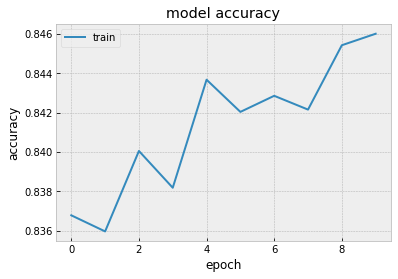

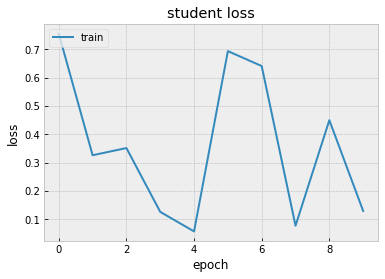

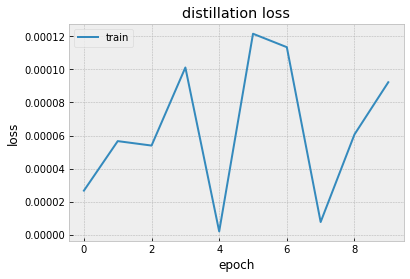

In [ ]:
#summary history for accuracy
plt.plot(hist6.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for loss
plt.plot(hist6.history['student_loss'])
#plt.plot(history.history['val_loss'])
plt.title('student loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summary history for distillation loss
plt.plot(hist6.history['distillation_loss'])
#plt.plot(history.history['val_loss'])
plt.title('distillation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
distiller_3.evaluate(test_data_generator)

1070/1070 [==============================] - 157s 146ms/step - sparse_categorical_accuracy: 0.8279 - student_loss: 0.4952


[0.8279004693031311, 0.7326439619064331]

In [ ]:
all_labels = ['0','1','2','3','4']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1070/1070 [==============================] - 155s 145ms/step


0.5005322888515242

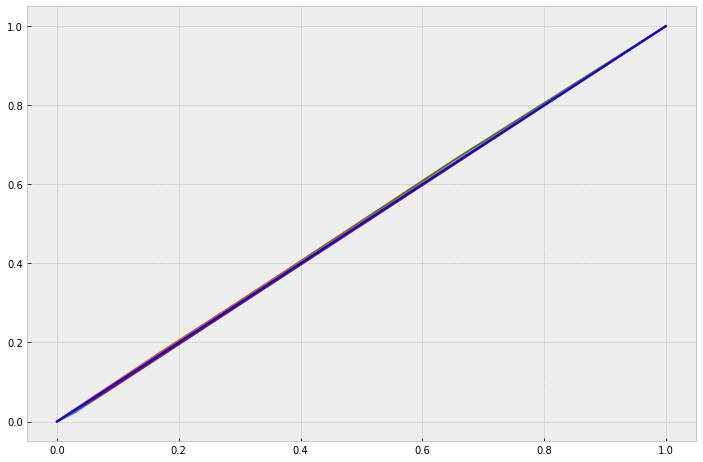

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
test_data_generator.reset() # resetting generator
y_pred = distiller.predict_generator(test_data_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_data_generator.classes, y_pred)

**Training the student model from scratch**

In [23]:
# Train student as done usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# Train the student model from scratch.
student_scratch.fit(train_data_generator, epochs=5)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1070/1070 [==============================] - 188s 174ms/step - loss: 1.1014 - sparse_categorical_accuracy: 0.6167
Epoch 2/5
1070/1070 [==============================] - 167s 156ms/step - loss: 1.0268 - sparse_categorical_accuracy: 0.6294
Epoch 3/5
1070/1070 [==============================] - 170s 158ms/step - loss: 0.9831 - sparse_categorical_accuracy: 0.6432
Epoch 4/5
1070/1070 [==============================] - 169s 158ms/step - loss: 0.9523 - sparse_categorical_accuracy: 0.6533
Epoch 5/5
1070/1070 [==============================] - 169s 158ms/step - loss: 0.9215 - sparse_categorical_accuracy: 0.6560


In [24]:
#Evaluate student model trained from scartch
student_scratch.evaluate(test_data_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


1070/1070 [==============================] - 158s 147ms/step - loss: 0.9229 - sparse_categorical_accuracy: 0.6572


[0.9228644967079163, 0.657202959060669]